# 1. Loading the CSV

In [1]:
import pandas as pd
data = pd.read_csv("../input/aaic-assignment-tl/labels_final.csv")

In [2]:
data.head()

,path,label
0,imagesv/v/o/h/voh71d00/509132755+-2755.tif,3
1,imagesl/l/x/t/lxt19d00/502213303.tif,3
2,imagesx/x/e/d/xed05a00/2075325674.tif,2
3,imageso/o/j/b/ojb60d00/517511301+-1301.tif,3
4,imagesq/q/z/k/qzk17e00/2031320195.tif,7


## 1.1 Splitting the CSV for train and test

In [3]:
from numpy.random import RandomState

train = data.sample(frac=0.8, random_state=RandomState())

test = data.loc[~data.index.isin(train.index)]

In [4]:
train.head()

,path,label
27312,imagest/t/c/y/tcy44f00/0060364798.tif,0
43153,imagesm/m/k/p/mkp52c00/2074743915.tif,1
5671,imagesc/c/w/v/cwv21e00/86002887_86002897.tif,6
37143,imagesv/v/p/p/vpp22d00/2502146073_6079.tif,5
45825,imagesc/c/f/o/cfo36d00/50578639-8639.tif,6


In [5]:
train.reset_index(inplace=True)
len(train)

38400

In [6]:
test.head()

,path,label
7,imagese/e/r/m/erm31f00/0001442842.tif,7
9,imagesi/i/w/i/iwi42d00/2020355073.tif,5
10,imagesx/x/v/b/xvb27e00/2028702546.tif,5
12,imagesa/a/n/f/anf94e00/1004863158.tif,0
14,imagesq/q/h/r/qhr31f00/0001438485.tif,1


In [7]:
test.reset_index(inplace=True)
len(test)


9600

## 1.2 Using Spliited CSV to create Train and Test Images 

In [8]:
import os 
os.chdir("/kaggle/working")
os.mkdir("Train")
os.chdir("Train")
for i in range(16):
    os.mkdir(str(i))

In [9]:
os.chdir("/kaggle/working")
os.mkdir("Test")
os.chdir("Test")
for i in range(16):
    os.mkdir(str(i))

In [10]:
import os
os.chdir("/kaggle/working")


In [11]:
import shutil
from tqdm import tqdm
for i in tqdm(range(len(train))):
  for j in range(16): #since there are 0-15 classes
    if (train['label'][i])==j:
        try:
            shutil.copy('../input/aaic-assignment-tl/data_final/'+train['path'][i],'/kaggle/working/Train/'+str(j) +'/')
        except:
            pass
    else:
      continue

100%|██████████| 38400/38400 [10:25<00:00, 61.36it/s]


In [12]:
for i in tqdm(range(len(test))):
  for j in range(16):
    if (test["label"][i])==j:
        try:
            shutil.copy('../input/aaic-assignment-tl/data_final/'+test['path'][i],"/kaggle/working/Test/"+str(j)+'/')
        except:
            pass
    else:
      continue

100%|██████████| 9600/9600 [02:17<00:00, 70.07it/s]


# 2. Data Augmentation with Batches

In [13]:
import tensorflow as tf
tf.keras.backend.clear_session()
from keras.preprocessing.image import ImageDataGenerator
data_train = ImageDataGenerator(
    rescale=1./255, #rescaling [0,1]
    rotation_range=15,
    width_shift_range=0.4, #shift the image to the left or right horzontaly
    height_shift_range=0.4,# shift vertically
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, #Randomly flip inputs horizontally.
    fill_mode='nearest', #filling the area
)

train_data = data_train.flow_from_directory("/kaggle/working/Train",target_size =(224,224),batch_size =64)

########################################################

data_test = ImageDataGenerator(
    rescale = 1./255
)

test_data = data_test.flow_from_directory("/kaggle/working/Test",target_size = (224,224),batch_size =64)

Found 38397 images belonging to 16 classes.
Found 9600 images belonging to 16 classes.


# 3. Building Model-1

<pre>
1. Use <a href='https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16'>VGG-16</a> pretrained network without Fully Connected layers and initilize all the weights with Imagenet trained weights. 
2. After VGG-16 network without FC layers, add a new Conv block ( 1 Conv layer and 1 Maxpooling ), 2 FC layers and a output layer to classify 16 classes. You are free to choose any hyperparameters/parameters of conv block, FC layers, output layer. 
3. Final architecture will be <b>INPUT --> VGG-16 without Top layers(FC) --> Conv Layer --> Maxpool Layer --> 2 FC layers --> Output Layer</b>
4. Train only new Conv block, FC layers, output layer. Don't train the VGG-16 network. 

</pre>

In [14]:
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Lambda

def model_1():
  vgg16 = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (224, 224, 3),)
  for layer in vgg16.layers:
    layer.trainable=False
  vgg16_output = vgg16.output
  
  #CONV-Block
  conv_1 = layers.Conv2D(1024,(3,3))(vgg16_output)
  max_pool =layers.MaxPool2D(2,2)(conv_1)
  
  #flatting_layer
  flat = layers.Flatten()(max_pool)

  # 2- Fully Connected Layer
  FC_layer_1 = layers.Dense(512,activation="relu")(flat)
  FC_layer_2 = layers.Dense(256,activation="relu")(FC_layer_1)

  #Outputlayer
  output_layer = layers.Dense(16,activation="softmax")(FC_layer_2)
  model = Model(inputs = vgg16.input, outputs = output_layer)
  return model


model_1 = model_1()
model_1.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [15]:
os.chdir("/kaggle/working")
os.mkdir("Model")

## 3.1 Training Model-1

In [16]:
os.chdir("/kaggle/working")

from tensorflow.keras.callbacks import  ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard, EarlyStopping


def Train_Model_1(): 
  epochs = 15
  opt = tf.keras.optimizers.Adam(0.0001)
    
  metrics = ["acc"] #sice its clasification 
  log_dir = "/kaggle/working/Model/callbacks_1"
                                                                             #using recall and Precsion 
  model_1.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics) 
  callbacks = [
        ModelCheckpoint("/kaggle/working/Model/model_1.h5",monitor = 'val_acc',save_best_only=True),
        ReduceLROnPlateau(monitor='val_acc', factor=0.6,mode='max', patience=2), #Reducing learing rate by factor of(0.6),
                                                                       # new_lr = lr * factor.
        CSVLogger("./data.csv"),
        TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True),
        EarlyStopping(monitor='val_acc', patience=5,mode= 'max',restore_best_weights=True) #stop traing is val_loss does not change
    ]
  history = model_1.fit(train_data,
                        steps_per_epoch = 38400//64,
                        validation_data=test_data,validation_steps =9600//64,
                        epochs=epochs,
                        callbacks=callbacks)                                                                             #after 20 epochs.
  tf.keras.models.save_model(model_1,'/kaggle/working/Model/final_model_1.h5')
  
  
  return history





In [17]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [18]:
import sys
if __name__ == '__main__':
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    sess = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(sess)

    if len(sys.argv) > 1:
        gpu = sys.argv[1]
    device = '/device:GPU:0'   #using Gpu for paced training

    with tf.device(device):
        history_1 = Train_Model_1()

Epoch 1/15
600/600 [==============================] - 622s 1s/step - loss: 2.1662 - acc: 0.3147 - val_loss: 1.6155 - val_acc: 0.4946
Epoch 2/15
600/600 [==============================] - 564s 940ms/step - loss: 1.7034 - acc: 0.4613 - val_loss: 1.5305 - val_acc: 0.5290
Epoch 3/15
600/600 [==============================] - 549s 915ms/step - loss: 1.5738 - acc: 0.5042 - val_loss: 1.4282 - val_acc: 0.5475
Epoch 4/15
600/600 [==============================] - 545s 908ms/step - loss: 1.4980 - acc: 0.5264 - val_loss: 1.4279 - val_acc: 0.5643
Epoch 5/15
600/600 [==============================] - 546s 910ms/step - loss: 1.4733 - acc: 0.5391 - val_loss: 1.3865 - val_acc: 0.5707
Epoch 6/15
600/600 [==============================] - 553s 922ms/step - loss: 1.4465 - acc: 0.5426 - val_loss: 1.3261 - val_acc: 0.5870
Epoch 7/15
600/600 [==============================] - 551s 917ms/step - loss: 1.4029 - acc: 0.5590 - val_loss: 1.3000 - val_acc: 0.6021
Epoch 8/15
600/600 [==============================]

In [19]:
#Instantly create a public HTTPS url for a website running locally on your development machine
#https://ngrok.com/docs

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
LOG_DIR = '/kaggle/working/Model/callbacks_1' # Here you need to enter the name of the file to be seen tensorboard
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2021-07-23 15:13:56--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 50.19.6.110, 3.212.203.64, 3.219.172.47, ...
Connecting to bin.equinox.io (bin.equinox.io)|50.19.6.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  18.6MB/s    in 0.7s    

2021-07-23 15:13:57 (18.6 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://df2470cc1ecb.ngrok.io


Text(0.5, 1.0, 'Training and Validation Accuracy')

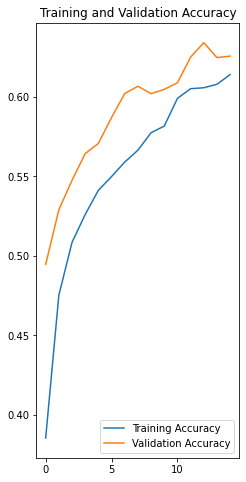

In [20]:
import matplotlib.pyplot as plt
epochs =15
acc = history_1.history['acc']
val_acc = history_1.history['val_acc']
loss=history_1.history['loss']
val_loss=history_1.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



# 4. Building Model-2

<pre>
1. Use <a href='https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16'>VGG-16</a> pretrained network without Fully Connected layers and initilize all the weights with Imagenet trained weights.
2. After VGG-16 network without FC layers, don't use FC layers, use conv layers only as Fully connected layer. any FC layer can be converted to a CONV layer. This conversion will reduce the No of Trainable parameters in FC layers. For example, an FC layer with K=4096 that is looking at some input volume of size 7×7×512 can be equivalently expressed as a CONV layer with F=7,P=0,S=1,K=4096. In other words, we are setting the filter size to be exactly the size of the input volume, and hence the output will simply be 1×1×4096 since only a single depth column “fits” across the input volume, giving identical result as the initial FC layer. You can refer <a href='http://cs231n.github.io/convolutional-networks/#convert'>this</a> link to better understanding of using Conv layer in place of fully connected layers.
3. Final architecture will be VGG-16 without FC layers(without top), 2 Conv layers identical to FC layers, 1 output layer for 16 class classification. <b>INPUT --> VGG-16 without Top layers(FC) --> 2 Conv Layers identical to FC --> Output Layer</b>
3. Train only last 2 Conv layers identical to FC layers, 1 output layer. Don't train the VGG-16 network. 
</pre>

In [22]:
tf.keras.backend.clear_session()

def model_2():
  vgg16 = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (224, 224, 3),)
  for layer in vgg16.layers:
    layer.trainable=False
  vgg16_output = vgg16.output
  
  #CONV-Block simliar to FC-Layer
  conv_1 = layers.Conv2D(4096,(7,7),activation = 'relu')(vgg16_output)
  conv_2 = layers.Conv2D(4096,(1,1),activation = 'relu')(conv_1)
  
  #flatting_layer
  flat = layers.Flatten()(conv_2)

  #Outputlayer
  output_layer = layers.Dense(16,activation="softmax")(flat)
  model = Model(inputs = vgg16.input, outputs = output_layer)
  return model


model_2 = model_2()
model_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## 4.1 Training Model-2

In [25]:
os.chdir("/kaggle/working")

def Train_Model_2(): 
  epochs = 20
  opt = tf.keras.optimizers.RMSprop(
    learning_rate=0.0001,
    rho=0.9,
    momentum=0.01,
    epsilon=1e-07,
    centered=True,
    name="RMSprop",
)
  metrics = ["acc"] #sice its clasification 
  log_dir = "/kaggle/working/Model/callbacks_2"
                                                                             #using recall and Precsion 
  model_2.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics) 
  callbacks = [
        ModelCheckpoint("/kaggle/working/Model/model_2.h5",monitor = 'val_acc',save_best_only=True),
        ReduceLROnPlateau(monitor='val_acc', factor=0.6,mode='max', patience=2), #Reducing learing rate by factor of(0.6),
                                                                       # new_lr = lr * factor.
        CSVLogger("./data.csv"),
        TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True),
        EarlyStopping(monitor='val_acc', patience=5,mode= 'max',restore_best_weights=True) #stop traing is val_loss does not change
    ]
  history = model_2.fit(train_data,
                        steps_per_epoch =  38400//64,
                        validation_data=test_data,validation_steps =9600//64,
                        epochs=epochs,
                        callbacks=callbacks)                                                                             #after 20 epochs.
  tf.keras.models.save_model(model_2,'/kaggle/working/Model/final_model_2.h5')
  
  
  return history





In [26]:
if __name__ == '__main__':
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    sess = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(sess)

    if len(sys.argv) > 1:
        gpu = sys.argv[1]
    device = '/device:GPU:0'   #using Gpu for paced training

    with tf.device(device):
        history_2 = Train_Model_2()

Epoch 1/20
600/600 [==============================] - 576s 959ms/step - loss: 1.6560 - acc: 0.4736 - val_loss: 1.5144 - val_acc: 0.5254
Epoch 2/20
600/600 [==============================] - 597s 994ms/step - loss: 1.5629 - acc: 0.5038 - val_loss: 1.5693 - val_acc: 0.5066
Epoch 3/20
600/600 [==============================] - 562s 937ms/step - loss: 1.5186 - acc: 0.5148 - val_loss: 1.4595 - val_acc: 0.5341
Epoch 4/20
600/600 [==============================] - 587s 979ms/step - loss: 1.4795 - acc: 0.5319 - val_loss: 1.4213 - val_acc: 0.5594
Epoch 5/20
600/600 [==============================] - 609s 1s/step - loss: 1.4478 - acc: 0.5461 - val_loss: 1.3357 - val_acc: 0.5824
Epoch 6/20
600/600 [==============================] - 613s 1s/step - loss: 1.4136 - acc: 0.5543 - val_loss: 1.3616 - val_acc: 0.5769
Epoch 7/20
600/600 [==============================] - 565s 941ms/step - loss: 1.3858 - acc: 0.5604 - val_loss: 1.3450 - val_acc: 0.5795
Epoch 8/20
600/600 [==============================] - 

In [31]:

LOG_DIR = '/kaggle/working/Model/callbacks_2' # Here you need to enter the name of the file to be seen tensorboard
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://e6268daa7d95.ngrok.io


Text(0.5, 1.0, 'Training and Validation Accuracy')

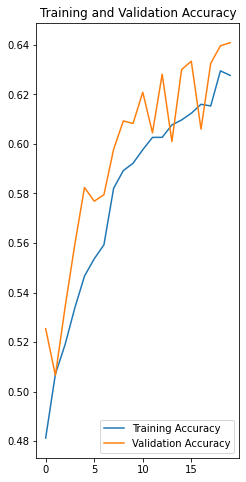

In [28]:
import matplotlib.pyplot as plt
epochs =20
acc = history_2.history['acc']
val_acc = history_2.history['val_acc']
loss=history_2.history['loss']
val_loss=history_2.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# 5. Building Model-3

<pre>
1. Use same network as Model-2 '<b>INPUT --> VGG-16 without Top layers(FC) --> 2 Conv Layers identical to FC --> Output Layer</b>' and train only Last 6 Layers of VGG-16 network, 2 Conv layers identical to FC layers, 1 output layer.
</pre>

In [32]:
vgg16 = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape = (224, 224, 3),)
len(vgg16.layers)

19

<pre>As I observed that there are 19 layers in VGG-16 without inlcuing to, and  I have to train the last 6 layers
So, 19-6 = 13, Therfore i am maikng 13 layers as non-trainable and rest will get trained while training.<\pre>

In [15]:
tf.keras.backend.clear_session()
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Lambda

def model_3():
  vgg16 = tf.keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (224, 224, 3),)
  for layer in vgg16.layers[:13]:
    layer.trainable=False
  vgg16_output = vgg16.output
  
  #CONV-Block simliar to FC-Layer
  conv_1 = layers.Conv2D(4096,(7,7),activation = 'relu')(vgg16_output)
  conv_2 = layers.Conv2D(4096,(1,1),activation = 'relu')(conv_1)
  
  #flatting_layer
  flat = layers.Flatten()(conv_2)

  #Outputlayer
  output_layer = layers.Dense(16,activation="softmax")(flat)
  model = Model(inputs = vgg16.input, outputs = output_layer)
  return model


model_3 = model_3()
model_3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## 5.1 Training Model-3

In [19]:
os.chdir("/kaggle/working")
from tensorflow.keras.callbacks import  ModelCheckpoint, ReduceLROnPlateau, CSVLogger, TensorBoard, EarlyStopping


def Train_Model_3(): 
  epochs = 50
  opt = tf.keras.optimizers.Adam(0.0001)
  metrics = ["acc"] #sice its clasification 
  log_dir = "/kaggle/working/Model/callbacks_3"
                                                                             #using recall and Precsion 
  model_3.compile(loss="categorical_crossentropy", optimizer=opt, metrics=metrics) 
  callbacks = [
        ModelCheckpoint("/kaggle/working/Model/model_3.h5",monitor = 'val_acc',save_best_only=True),
        ReduceLROnPlateau(monitor='val_acc', factor=0.6,mode='max', patience=2), #Reducing learing rate by factor of(0.6),
                                                                       # new_lr = lr * factor.
        CSVLogger("./data.csv"),
        TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True),
        EarlyStopping(monitor='val_acc', patience=5,mode= 'max',restore_best_weights=True) #stop traing is val_loss does not change
    ]
  history = model_3.fit(train_data,
                        steps_per_epoch = 38400//64,
                        validation_data=test_data,validation_steps =9600//64,
                        epochs=epochs,
                        callbacks=callbacks)                                                                             #after 20 epochs.
  tf.keras.models.save_model(model_3,'/kaggle/working/Model/final_model_3.h5')
  
  
  return history


In [20]:
import sys
if __name__ == '__main__':
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    sess = tf.compat.v1.Session(config=config)
    tf.compat.v1.keras.backend.set_session(sess)

    if len(sys.argv) > 1:
        gpu = sys.argv[1]
    device = '/device:GPU:0'   #using Gpu for paced training

    with tf.device(device):
        history_3 = Train_Model_3()

Epoch 1/50
600/600 [==============================] - 658s 1s/step - loss: 1.9007 - acc: 0.3953 - val_loss: 1.3520 - val_acc: 0.5849
Epoch 2/50
600/600 [==============================] - 647s 1s/step - loss: 1.3254 - acc: 0.5837 - val_loss: 1.1076 - val_acc: 0.6628
Epoch 3/50
600/600 [==============================] - 643s 1s/step - loss: 1.2051 - acc: 0.6279 - val_loss: 1.0998 - val_acc: 0.6750
Epoch 4/50
600/600 [==============================] - 629s 1s/step - loss: 1.1039 - acc: 0.6563 - val_loss: 1.0297 - val_acc: 0.6814
Epoch 5/50
600/600 [==============================] - 620s 1s/step - loss: 1.0325 - acc: 0.6778 - val_loss: 0.9490 - val_acc: 0.7153
Epoch 6/50
600/600 [==============================] - 616s 1s/step - loss: 0.9738 - acc: 0.6972 - val_loss: 0.9610 - val_acc: 0.7202
Epoch 7/50
600/600 [==============================] - 611s 1s/step - loss: 0.9338 - acc: 0.7146 - val_loss: 0.9392 - val_acc: 0.7267
Epoch 8/50
600/600 [==============================] - 612s 1s/step - 

In [21]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
LOG_DIR = '/kaggle/working/Model/callbacks_3' # Here you need to enter the name of the file to be seen tensorboard
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2021-07-24 19:24:44--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.45.123.219, 52.4.80.235, 35.169.250.74, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.45.123.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  14.1MB/s    in 0.9s    

2021-07-24 19:24:45 (14.1 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://cdc24e02ed81.ngrok.io


Text(0.5, 1.0, 'Training and Validation Accuracy')

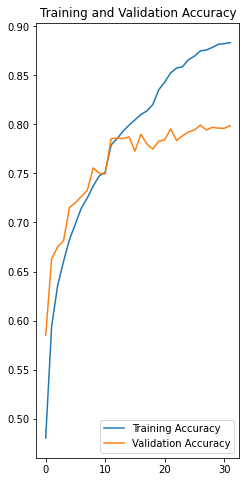

In [23]:
import matplotlib.pyplot as plt
epochs =32
acc = history_3.history['acc']
val_acc = history_3.history['val_acc']
loss=history_3.history['loss']
val_loss=history_3.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

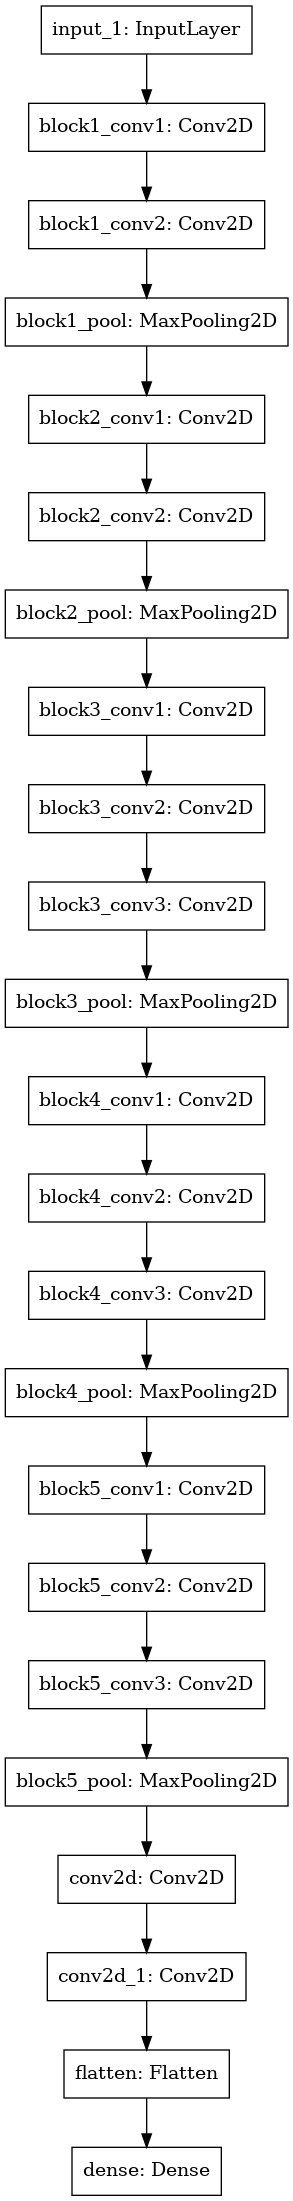

In [25]:
tf.keras.utils.plot_model(
    model_3,
    to_file="model_1.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)